In [ ]:
# Pour que les changements dans les modules importés (par exemple sam_utils.py) soient pris en compte
%load_ext autoreload
%autoreload 2
# Pour afficher les figures dans le notebook
%matplotlib inline

Utiliser le code de la cellule ci-dessous pour désactiver le scrolling quand l'affichage est long.

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D
from scipy.signal import convolve2d, convolve, lfilter, hamming
from scipy.io import wavfile  # Pour lire et écrire des fichiers sons

TensorFlow 2.x selected.


In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 4
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 15
mpl.rcParams['axes.grid'] = True
# mpl.rcParams.find_all('')

In [5]:
import os
from google.colab import drive
drive.mount('drive')
os.chdir('drive/My Drive/univ/master-2/sam/seance2')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
from sam_utils import plot_sound, plot_spectrum, db, add_noise, snr
image_path = Path('../data/images/')
sound_path = Path('../data/sons/')

7 séances de 4h:

* Analyse de Fourier, échantillonnage
* **Filtrage**
* Représentations et features de référence en audio et image (shallow learning)
* Apprentissage de représentations pour les données multimédia
* Apprentissage multimodal supervisé
* Apprentissage de métrique pour les données multimodales
* Extension


# Introduction: interpréter un filtre, au-delà du pattern matching?

## Lundi 8h, question à froid: qu'est-ce qu'une convolution?

## Exemple 1: pattern matching dans une image

Pattern entre les lignes 49 et 79, et le colonnes 151 et 199.
Pattern localisé à la ligne 64 et la colonne 175.


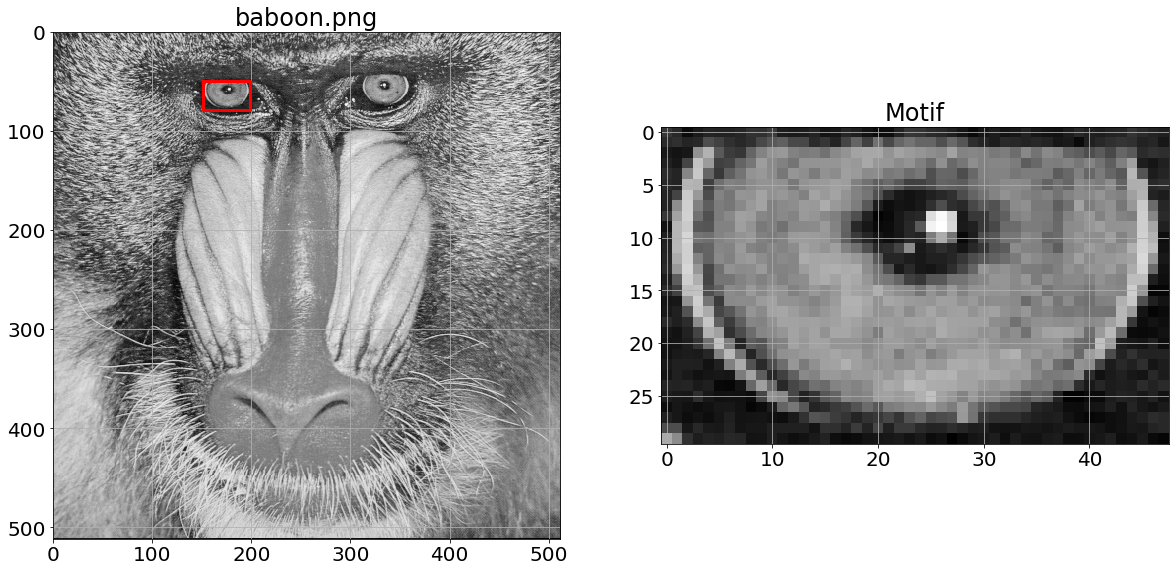

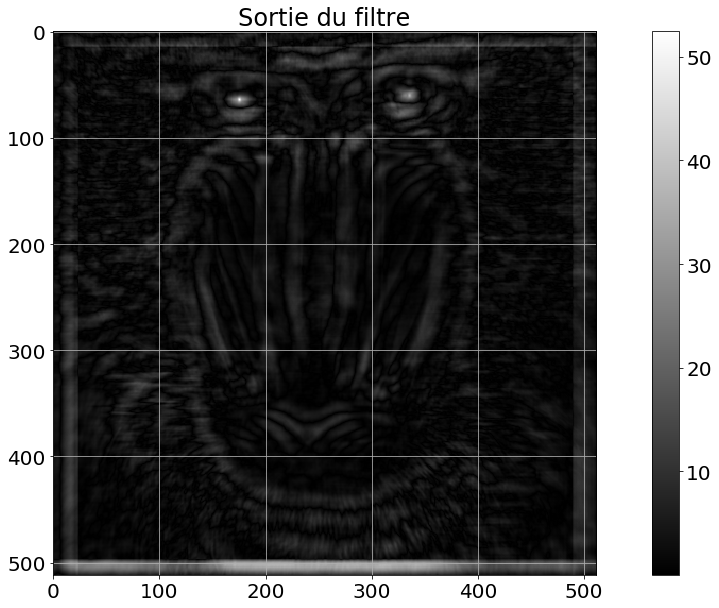

In [7]:
file = image_path / 'baboon.png'
img = plt.imread(str(file))

# Extraction du pattern 2D
i_min = 49
i_max = i_min + 30
j_min = 151
j_max = j_min + 48
print('Pattern entre les lignes {} et {}, et le colonnes {} et {}.'
      .format(i_min, i_max, j_min, j_max))

pattern = img[i_min:i_max, j_min:j_max]
pattern = pattern - np.mean(pattern)  # On utilise une version centrée

# Filtrage
y = convolve2d(in1=img, in2=pattern[::-1, ::-1], mode='same')

i_pattern, j_pattern = np.unravel_index(np.argmax(y), y.shape)
print('Pattern localisé à la ligne {} et la colonne {}.'
      .format(i_pattern, j_pattern))

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.plot([j_min, j_min, j_max, j_max, j_min],
         [i_min, i_max, i_max, i_min, i_min], 'r')
plt.title(str(file.name))
plt.subplot(122)
plt.imshow(pattern, cmap='gray')
plt.title('Motif')

plt.figure(figsize=(20, 10))
plt.imshow(np.abs(y), cmap='gray')
plt.title('Sortie du filtre')
plt.colorbar()

## Exemple 2: pattern matching 1D

Pattern entre les indices 1000 et 1123
Pic à n=1061


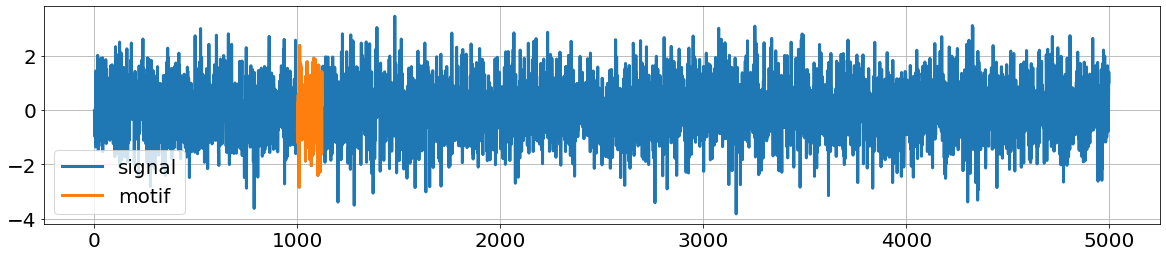

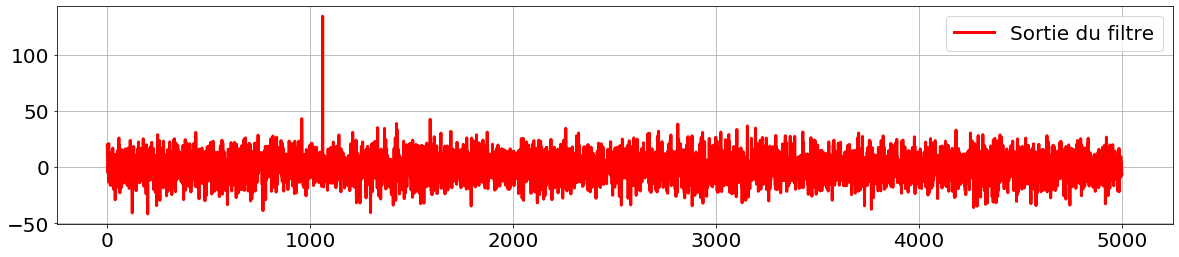

In [8]:
# Un signal composé de valeurs aléatoires
x_len = 5000
x = np.random.randn(x_len)

# On choisit une portion du signal comme pattern
i_start = 1000
i_end = i_start + 123
pattern = np.copy(x[i_start:i_end])
print('Pattern entre les indices {} et {}'.format(i_start, i_end))

# Convolution entre le signal et le pattern retourné
y = np.convolve(pattern[::-1], x, mode='same')

plt.figure()
plt.plot(x, label='signal')
plt.plot(np.arange(i_start, i_end), x[i_start:i_end], label='motif')
plt.legend()

plt.figure()
plt.plot(y, 'r', label='Sortie du filtre')
plt.legend()

print('Pic à n={}'.format(np.argmax(y)))

Astuce: comment faire la même chose en remplaçant ```y = np.convolve(pattern[::-1], x, mode='same')``` par un CNN?

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5000, 1)           123       
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________
None


(1000, 1123)

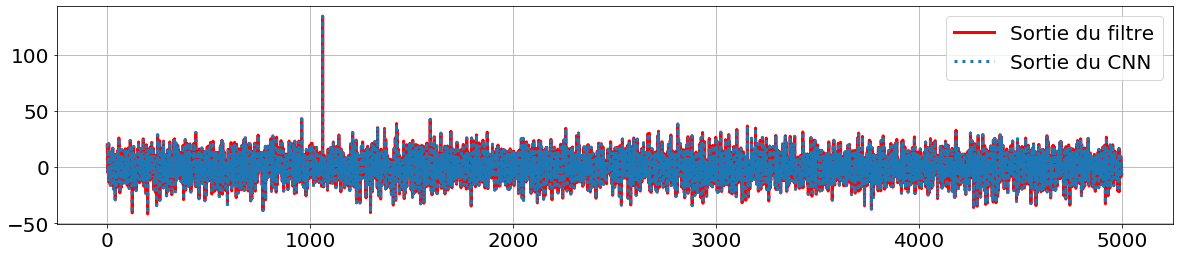

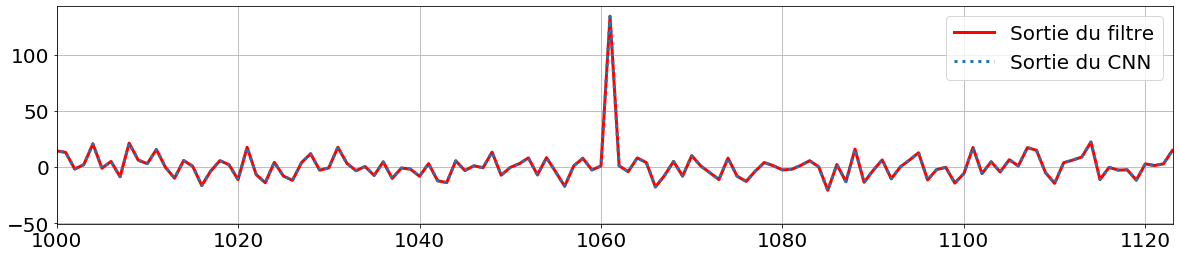

In [9]:
# Build CNN
model = Sequential()
# Note that input shape should be (x_len, n_input_channels)
conv_layer = Conv1D(filters=1, kernel_size=(pattern.size, ), padding='same',
                    activation='linear', strides=1, input_shape=(x_len, 1),
                    use_bias=False)
model.add(conv_layer)
# Note that weight shape should be (filter length, n_input_channels, n_filters)
conv_layer.set_weights([pattern[:, None, None]])
print(model.summary())

# Apply filter
# Note that input shape should be (n_examples, x_len, n_input_channels)
y_cnn = model.predict(x[None, :, None])
# Note that output shape is (n_examples, y_len, n_filters)
y_cnn = y_cnn[0, :, 0]

plt.figure()
plt.plot(y, 'r', label='Sortie du filtre')
plt.plot(y_cnn, ':', label='Sortie du CNN')
plt.legend()

plt.figure()
plt.plot(y, 'r', label='Sortie du filtre')
plt.plot(y_cnn, ':', label='Sortie du CNN')
plt.legend()
plt.xlim(i_start, i_end)

## Exemple 3: apprendre un filtre qui débruite
On cherche à apprendre à enlever le bruit ajouté à une sinusoïde.

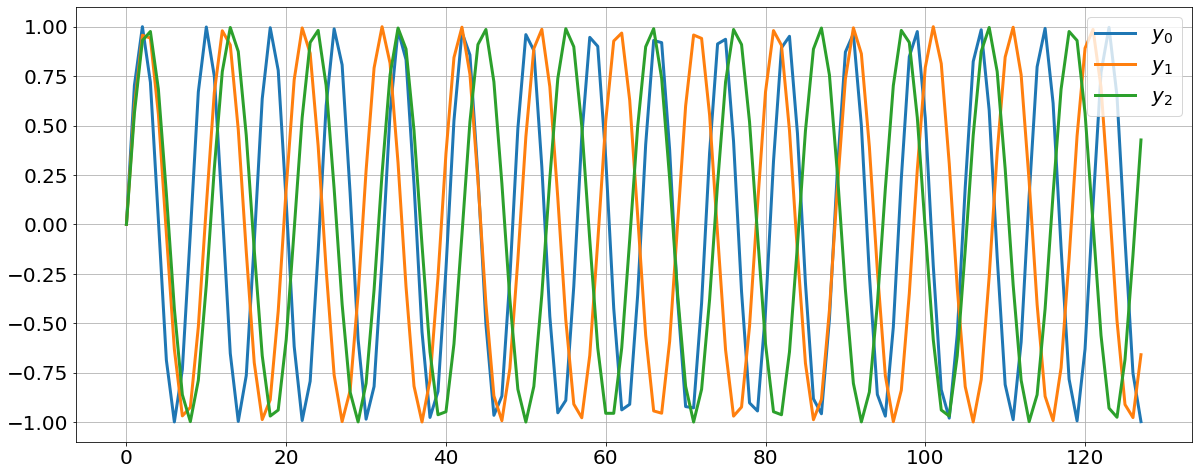

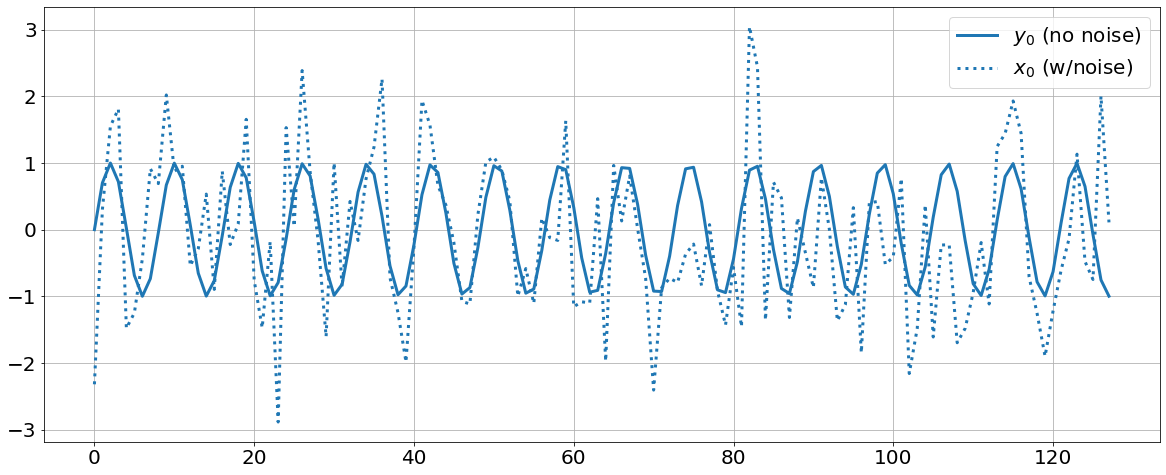

In [10]:
#############
# Les données
#############
n_examples = 50
x_len = 128

# Ensemble d'entrainement: des sinus purs avec des fréquences tirées aléatoirement autour de fc
fc = 0.1
df = 0.05
nu0_train = fc + np.random.rand(n_examples) * df - df / 2
y_true_train = np.sin(2 * np.pi * nu0_train[:, None] * np.arange(x_len)[None, :])
x_train = y_true_train + 10 ** 0 * np.random.randn(n_examples, x_len)

# Test set: signals with same 
nu0_test = fc + np.random.rand(n_examples) * df - df / 2
y_true_test = np.sin(2 * np.pi * nu0_test[:, None] * np.arange(x_len)[None, :])
x_test = y_true_test + 10 ** 0 * np.random.randn(n_examples, x_len)

plt.figure(figsize=(20, 8))
for i in range(3):
    plt.plot(y_true_train[i, :], '-', label='$y_{}$'.format(i))
plt.legend(loc='upper right')

plt.figure(figsize=(20, 8))
i = 0
p = plt.plot(y_true_train[i, :], '-', label='$y_0$ (no noise)'.format(i))
plt.plot(x_train[i, :], ':', label='$x_0$ (w/noise)'.format(i), color=p[0].get_color())
plt.legend(loc='upper right')

On construit un réseau composé d'une couche convolutive avec un filtre et une fonction d'activation linéaire. On optimise les poids du filtre en minimisant l'erreur aux moindres carrés.

Text(0.5, 1.0, 'Loss')

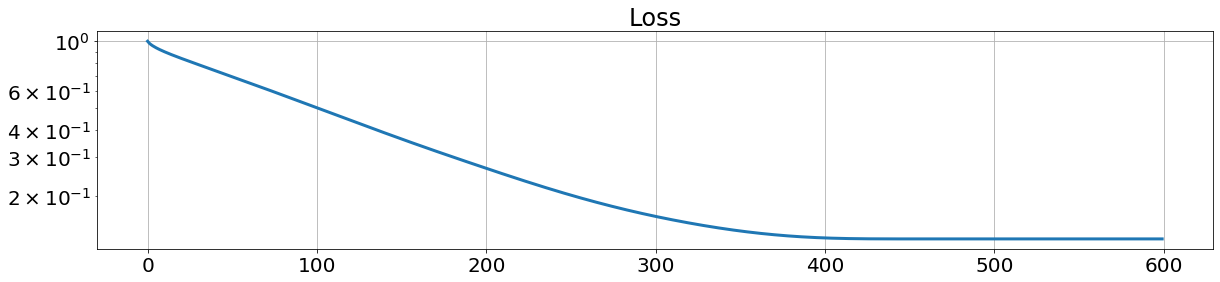

In [11]:
# Define and learn filter
h_len = 13

learning_model = Sequential()
# Note that input shape should be (x_len, n_input_channels)
conv_layer = Conv1D(filters=1, kernel_size=(h_len, ), padding='same',
                    activation='linear', strides=1, input_shape=(x_len, 1),
                    use_bias=False, name='fir')
learning_model.add(conv_layer)
learning_model.compile(optimizer='rmsprop', loss='mse')
history = learning_model.fit(x_train[:, :, None], y_true_train[:, :, None],
                             epochs=600, batch_size=n_examples, verbose=0)

plt.figure()
plt.semilogy(history.history['loss'])
plt.title('Loss')

Un aperçu des résultats sur l'ensemble de test.
Pour mesurer la qualité d'un signal $\widehat{y}$ par rapport au signal original $y$, on utilise le rapport signal à bruit (SNR)
$$SNR(\widehat{y}, y) = 20 \log \frac{\left\|y\right\|_2^2}{\left\|y-\widehat{y}\right\|_2^2}$$
qui d'autant plus élevé que $\widehat{y}$ proche de $y$.

SNR avant débruitage: -3.0089879486849775
SNR après débruitage: 6.3426338498384816


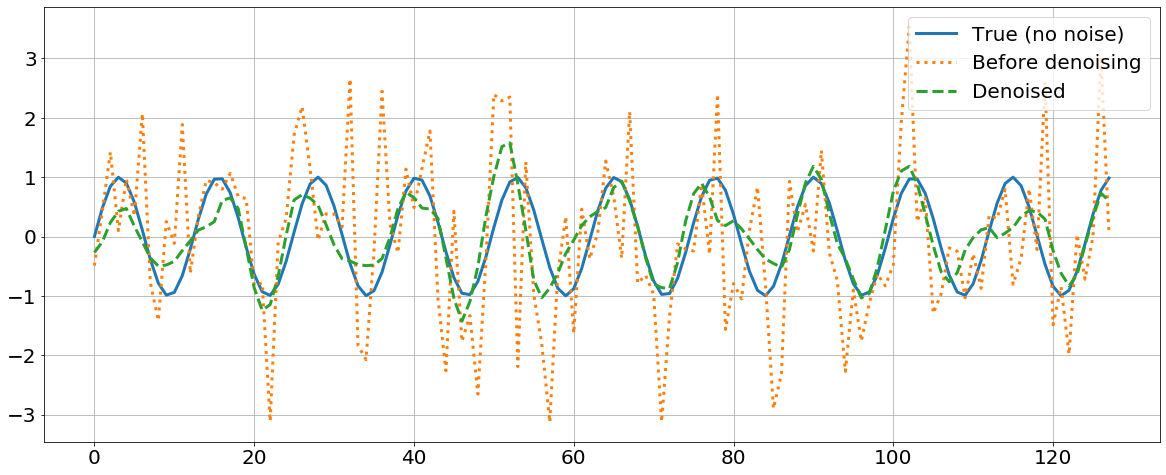

In [12]:
def db(x):
    return 20 * np.log10(np.abs(x))


def snr(x_est, x_true, axis=None):
    """ Signal-to-noise ratio """
    return db(np.linalg.norm(x_true, ord=2, axis=axis)
              / np.linalg.norm(x_est - x_true, ord=2, axis=axis))


y_learning_test = learning_model.predict(x_test[:, :, None])[:, :, 0]

print('SNR avant débruitage:',
      np.mean(snr(x_test, y_true_test, axis=1)))
print('SNR après débruitage:',
      np.mean(snr(y_learning_test, y_true_test, axis=1)))

plt.figure(figsize=(20, 8))
for i in range(1):
    plt.plot(y_true_test[i, :], '-', label='True (no noise)'.format(i))
    plt.plot(x_test[i, :], ':', label='Before denoising'.format(i))
    plt.plot(y_learning_test[i, :], '--', label='Denoised'.format(i))
plt.legend(loc='upper right')

## Visualisation du filtre appris
Comment interpréter ce qu'on a appris?

Text(0.5, 1.0, 'Filtre')

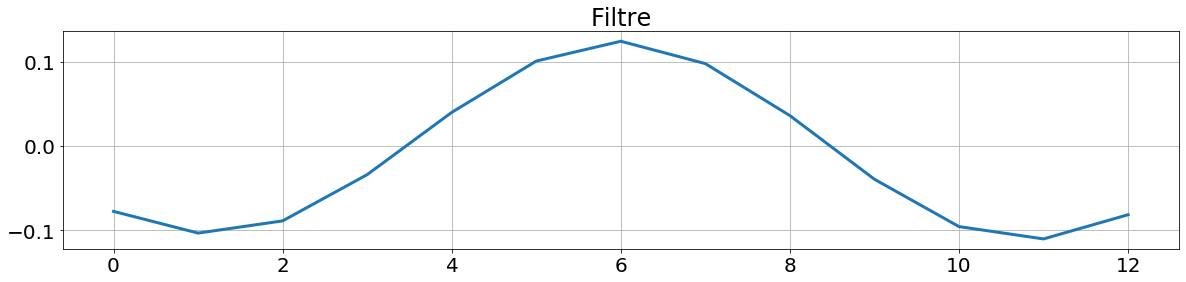

In [13]:
w_learning = learning_model.get_layer(name='fir').get_weights()[0].reshape(-1)

plt.figure()
plt.plot(w_learning)
plt.title('Filtre')

Text(0.5, 1.0, '"Réponse fréquentielle"')

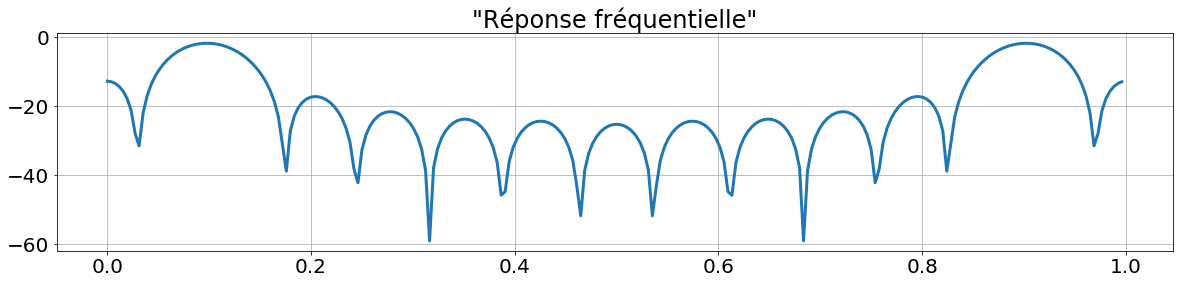

In [14]:
plt.figure()
n_bins = 256
plt.plot(np.arange(n_bins) / n_bins, db(np.fft.fft(w_learning, n_bins)))
plt.title('"Réponse fréquentielle"')

## Objectifs de la séance
Monter en compétence sur la notion de filtrage:
* Le produit de convolution: définition, propriétés
* Filtrage et convolution:
   * notion de filtre
   * notion de réponse impulsionnelle
   * notion de réponse fréquentielle
* Les filtres à réponse impulsionnelle finie
* Les filtres à réponse impulsionnelle infinie

# Le produit de convolution

## Cas de signaux définis sur $\mathbb{Z}$

Dans un premier temps, on s'intéresse aux signaux discrets $x[n], n\in\mathbb{Z}$ définis sur $\mathbb{Z}$. C'est un cas général qui inclut en particulier les vecteurs de taille $N$, que l'on peut étendre à $\mathbb{Z}$ en fixant $x[n]=0$ pour $n<0$ ou $n\geq N$.

Pour de tels signaux $x$ définis sur $\mathbb{Z}$, la transformée de Fourier de $x$ est définie pour toute fréquence $\nu\in[0,1]$ par
$$X[\nu]=\sum_{n\in\mathbb{Z}} x[n] e^{-i2\pi\nu n}$$

### Définition
Soit $x[n], h[n]\in\mathbb{R}, n\in\mathbb{Z}$ des signaux discrets définis sur $\mathbb{Z}$. Le *produit de convolution* $y = x * h$ entre $x$ et $h$ est un signal $y$ défini pour tout $n\in\mathbb{Z}$ par
$$y[n] = \sum_{m\in\mathbb{Z}} x[m] h[n-m]$$

### Interprétation
Pour $n\in\mathbb{Z}$ fixé, $y[n]$ est le produit scalaire entre $x$ et le signal $m\mapsto h[n-m]$. Ce dernier signal est une version retournée de $h$ (i.e., $m\mapsto h[-m]$) puis translatée de $n$.
Ainsi, lorsque $n$ varie, on fait "glisser" la version retournée de $h$ le long de $x$.

### Propriétés

Si $h, x, y$ sont des signaux définis sur $\mathbb{Z}$ et $\alpha\in\mathbb{R}$, on a les propriétés suivantes:
* **Commutativité**: on a $x*h=h*x$.
* **Bilinéarité**: on a $h*(x+\alpha \times y)=h*x+\alpha \times (h*y)$.
* **Associativité**: on a $h*(x*y)=(h*x)*y$.
* **Transformée de Fourier**: la transformée de Fourier $Y$ du produit de convolution $y=h*x$ est le produit des transformées de Fourier de $h$ et $x$: pour toute fréquence $\nu\in[0,1]$, on a
$$Y[\nu] = H[\nu] \times X[\nu]$$

### Exercices
* Faire les preuves des propriétés précédentes.
* Indentité: soit $h[n] = \delta[n]$ le signal qui vaut $1$ pour $n=0$ et $0$ partout ailleurs, appelé dirac en $0$; montrer que $h*x=x$.
* Retard pur: en fixant $n_0\in\mathbb{Z}$, soit $h[n] = \delta[n-n_0]$ le signal qui vaut $1$ pour $n=n_0$ et $0$ partout ailleurs, appelé dirac en $n_0$; montrer que $(h*x)[n]=x[n-n_0]$, c'est-à-dire $x$ retardé, translaté de $n_0$.

## Cas fini: convolution circulaire
Dans le cas de signaux de taille $N$ et si l'on souhaite utiliser la transformée de Fourier discrète (DFT), on utilise la convolution dite circulaire.

### Définition
On étend $x\in\mathbb{R}^N$ à $\mathbb{Z}$ en le périodisant: $\forall n\in\lbrace 0, \ldots, N-1\rbrace, \forall p\in\mathbb{Z}, x[n+pN] = x[n]$. On peut alors définir la convolution circulaire $y=h*x\in\mathbb{R}^N$ de $h$ et $x$ pour $n\in\lbrace 0, \ldots, N-1\rbrace$ par:
$$y[n] = \sum_{m=0}^{N-1} h[m] x[n-m]$$

### Illustration

### Propriétés
* Le principal intérêt est que la DFT du produit de convolution est le produit des DFT.
* Les autres propriétés sont conservées

### Complexité calculatoire
Pour $x, h\in\mathbb{R}^N$, quelle est la complexité temporelle pour calculer $x * h$ en appliquant la définition? Quelle est la complexité temporelle pour effectuer le même calcul en utilisant la DFT?

### Les effets de bord
Lorsque $h$ a un support de petite taille $M$ par rapport à la taille $N$ du signal $x$, il n'y a pas de différence entre les deux convolutions sauf "au bord", c'est-à-dire pour $n<M/2$ et $n>N-M/2$ environ.

Pour que la convolution circulaire donne le même résultat que la convolution originale (y compris aux bords), il suffit d'ajouter $N-1$ zeros à $x$ et $h$ puis de faire la convolution circulaire sur les signaux de taille $2N-1$. C'est ce que font la plupart des implémentations.

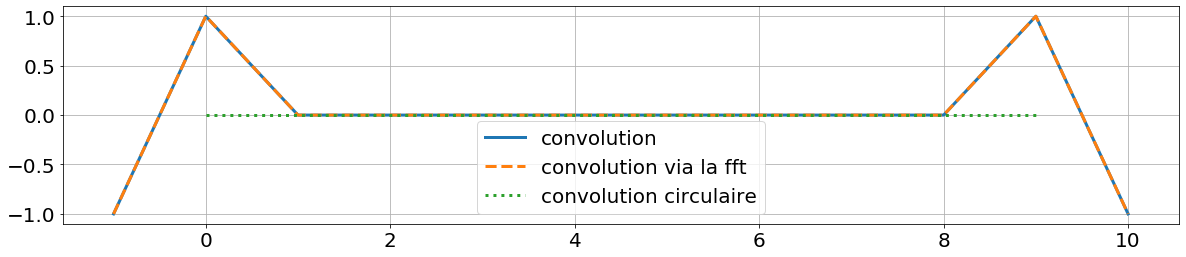

In [15]:
N = 10
x = np.ones(N)
h = [-1, 2, -1]
y = convolve(h, x, method='direct', mode='full')
y_fft = convolve(h, x, method='fft', mode='full')
h_pad = np.zeros_like(x)
h_pad[:3] = h
y_circ = np.real(np.fft.ifft(np.fft.fft(x) * np.fft.fft(h_pad)))
plt.plot(np.arange(N+2)-1, y, label='convolution')
plt.plot(np.arange(N+2)-1, y_fft, '--', label='convolution via la fft')
plt.plot(y_circ, ':', label='convolution circulaire')
plt.legend()

Différents modes permettent de sélectionner les coefficients à garder en supprimant éventuellement des coefficients aux bords: si $x$ est de taille $N$ et $h$ de taille $M$ et $y=x*h$,
* mode `full`: renvoie le vecteur $\left[y\left(0\right), \ldots, y\left(N+M\right)\right]$de taille $N+M-1$.
* mode `valid`: renvoie le vecteur $\left[y\left(\frac{M-1}{2}\right), \ldots, y\left(N-1\right)\right]$de taille $N-M+1$
* mode `same`: renvoie un vecteur de taille $N$ qui correspond à un alignement avec $x$ lorsque l'on considère que le support de $h$ est centré en 0 (voir schéma).

modes `full`/`same`/`valid` permettent de sélectionner les coefficients à garder en supprimant éventuellement des coefficients aux bordsfsDif modes `full`/`same`/`valid` permettent de sélectionner les coefficients à garder en supprimant éventuellement des coefficients aux bords modes `full`/`same`/`valid` permettent de sélectionner les coefficients à garder en supprimant éventuellement des coefficients aux bordsff.

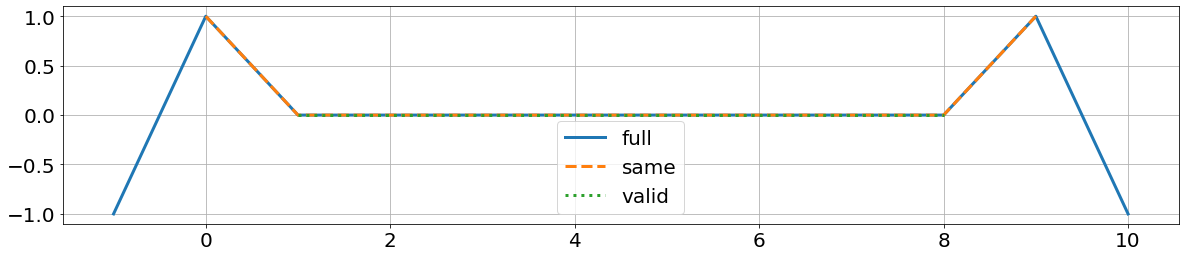

In [16]:
N = 10
x = np.ones(N)
h = [-1, 2, -1]
y_full = convolve(x, h, mode='full')
y_same = convolve(x, h, mode='same')
y_valid = convolve(x, h, mode='valid')
plt.plot(np.arange(N+2)-1, y_full, label='full')
plt.plot(y_same, '--', label='same')
plt.plot(np.arange(N-2)+1, y_valid, ':', label='valid')
plt.legend()

# Filtrage et convolution
Dans tout ce qui suit, on ne précisera pas si l'on se place dans le cas circulaire ou pas, ni quelle transformée de Fourier on considère (les précautions précédentes permettent d'envisager les deux cas).

## Notion de filtre
On considère des opérateurs $\mathcal{F}$ tels que pour tout signal $x$, $y=\mathcal{F}[x]$ est un signal.

**Définitions:**
* Pour $m\in\mathbb{Z}$, on définit l'opérateur de ***translation*** $T_m$ tels que pour tout signal $x$ et pour tout $n\in\mathbb{Z}$, $$\left(T_m [x]\right)[n] = x[n-m]$$
* On dit qu'un opérateur $\mathcal{F}$ est ***invariant par translation*** si l'image d'un signal translaté est la translation de l'image du signal : pour tout signal $x$, pour $m\in\mathbb{Z}$, on a
$$\mathcal{F}\left[T_m x\right] = T_m \mathcal{F}\left[x\right]$$.
* On appelle ***filtre linéaire*** tout opérateur linéaire invariant par translation.

## Notion de réponse impulsionnelle
**Définition.** Soit $\mathcal{F}$ un filtre linéaire et $\delta$ le dirac en $0$. Le signal $h=\mathcal{F}[\delta]$ est appelée ***réponse impultionnelle*** du filtre $\mathcal{F}$. 

**Théorème.** La réponse impulsionnelle caractérise complètement le filtre $\mathcal{F}$ et on a, pour tout signal $x$, $\mathcal{F}[x] = h * x$. Par abus de langage, on confond souvent un filtre $\mathcal{F}$ et sa réponse impulsionnelle $h$.

**Idée de la preuve.** Considérer $x$ comme une somme de diracs pondérés par chaque coefficient $x[n]$ puis utiliser les propriétés de linéarité et d'invariance par translation de $\mathcal{F}$, et la convolution par un dirac.

**Illustration: réponse impulsionnelle d'une salle.**

## Notion de réponse fréquentielle
La ***réponse fréquentielle*** d'un filtre $\mathcal{F}$ est la transformée de Fourier $H$ de sa réponse impulsionnelle $h$.

**Propriété.** La réponse fréquentielle caractérise complètement un filtre et signal $y$ obtenu en filtrant un signal $x$ par un filtre de réponse fréquentielle $H$ a pour transformée de Fourier $Y=H \times X$.

**Illustration: modèle source-filtre.**

# Conception de filtres FIR et IIR

Filtrage
$$y(n) = \sum_{j=0}^q b_j x(n-j) - \sum_{j=0}^p a_j y(n-j)$$
Réponse fréquentielle (transformée de Fourier discrète du filtre):
$$H(\nu)=\frac{\sum_{j=0}^q b_j e^{-2\mathbf{i}\pi\nu j}}{\sum_{j=0}^p a_j e^{-2i\pi\nu j}}, \nu\in[0,1],  \text{ (avec $a_0=1$})$$
Transformée en Z (TZ):
$$\mathcal{H}(z)=\frac{Q(z)}{P(z)}=\frac{\sum_{j=0}^q b_j z^{-j}}{\sum_{j=0}^p a_j z^{-j}}, z\in\mathbb{C}$$
Relation entre TZ et TFD:
$$H(\nu)=\mathcal{H}(e^{2i\pi\nu}), \nu\in[0,1]$$

In [ ]:
def plot_filter_response(b, a=[1], n_freq=1024, **kwargs):
    # Échelle fréquentielle discrète
    nu_scale = np.arange(n_freq) / n_freq
    
    b = np.array(b)
    numerator = np.zeros_like(nu_scale, dtype=complex)
    for j, bj in enumerate(b):
        numerator += bj * np.exp(-2*np.pi*1j*nu_scale*j)

    a = np.array(a)
    denominator = np.zeros_like(numerator)
    for i, ai in enumerate(a):
        denominator += ai * np.exp(-2*np.pi*1j*nu_scale*i)
        
    H = numerator/denominator

    plt.plot(nu_scale, 20*np.log10(np.abs(H)), **kwargs)
    plt.xlabel(r'$\nu$')
    

## Exemples de filtres FIR (zéros)

### Filtres moyenneurs (passe-bas)

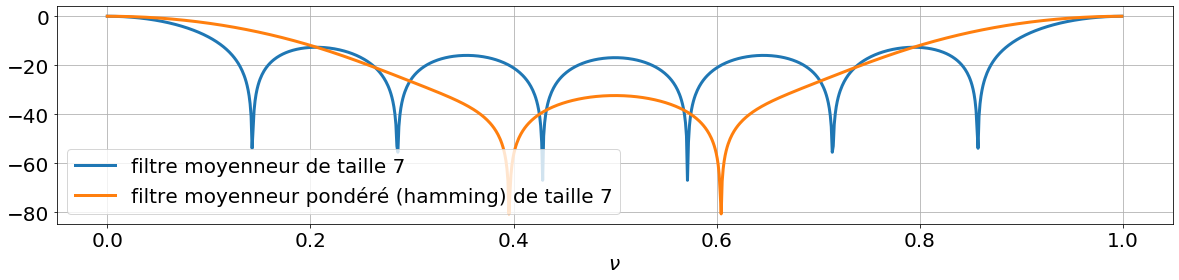

In [18]:
b = np.ones(7) / 7
plot_filter_response(b, label='filtre moyenneur de taille 7')
h = hamming(7)
h /= np.sum(h)
plot_filter_response(h, label='filtre moyenneur pondéré (hamming) de taille 7')
plt.legend()

### Filtres dérivateurs (passe-haut)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


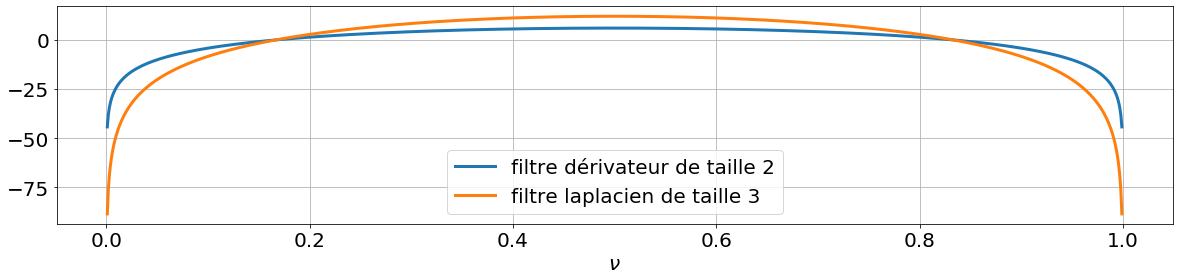

In [19]:
plot_filter_response(b=[-1, 1], label='filtre dérivateur de taille 2')
plot_filter_response(b=[-1, 2, -1], label='filtre laplacien de taille 3')
plt.legend()

### Design d'un filtre FIR avec un zéro à une fréquence $\nu_0$

$$
\left(1-r e^{-2 i \pi \nu_0}z^{-1}\right)\times\left(1-r e^{+2 i \pi \nu_0}z^{-1}\right)
=
1 - 2 r \cos\left(2\pi\nu_0\right)z^{-1}+r^2 z^{-2}
$$

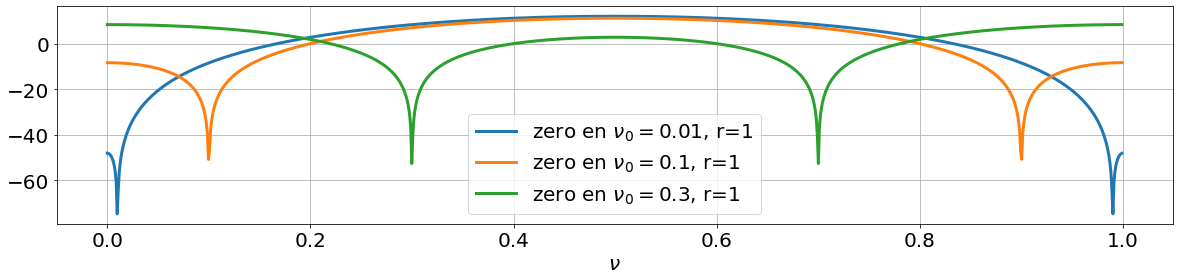

In [20]:
r = 1
for nu0 in [0.01, 0.1, 0.3]:
    b = [1, -2*r*np.cos(2*np.pi*nu0), r**2]
    plot_filter_response(b, label=r'zero en $\nu_0={}$, r={}'.format(nu0, r))
plt.legend()

Variation du module du zéro

Text(0.5, 1.0, 'Réponse impulsionnelle')

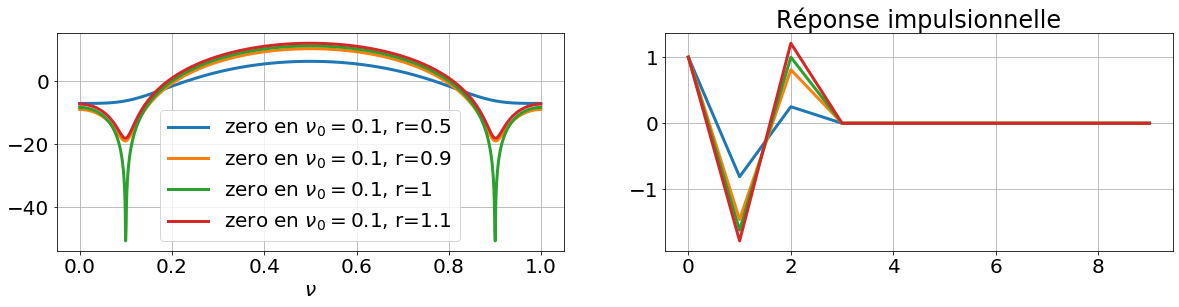

In [21]:
x = np.zeros(10)
x[0] = 1
nu0 = 0.1
a = [1]
sp = plt.subplots(1, 2)[1]
for r in [0.5, 0.9, 1, 1.1]:
    b = [1, -2*r*np.cos(2*np.pi*nu0), r**2]
    y = lfilter(b=b, a=a, x=x)

    plt.sca(sp[0])
    plot_filter_response(b, a=a, label=r'zero en $\nu_0={}$, r={}'.format(nu0, r))

    plt.sca(sp[1])
    plt.plot(y)

plt.sca(sp[0])
plt.legend()
plt.sca(sp[1])
plt.title('Réponse impulsionnelle')


## Exemples de filtres IIR (pôles)
Design d'un filtre IIR avec un pôle à une fréquence $\nu_0$

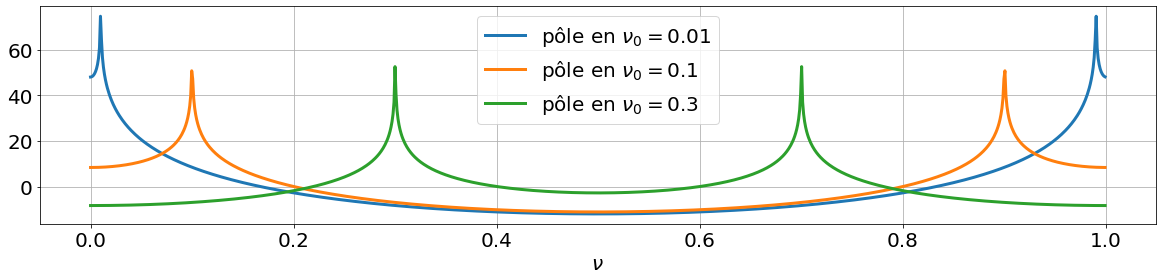

In [22]:
r = 1
for nu0 in [0.01, 0.1, 0.3]:
    a = [1, -2*r*np.cos(2*np.pi*nu0), r**2]
    plot_filter_response(b=[1], a=a, label=r'pôle en $\nu_0={}$'.format(nu0))
plt.legend()

Variation du module du pôle et mise en évidence d'une instabilié ($r>1$)

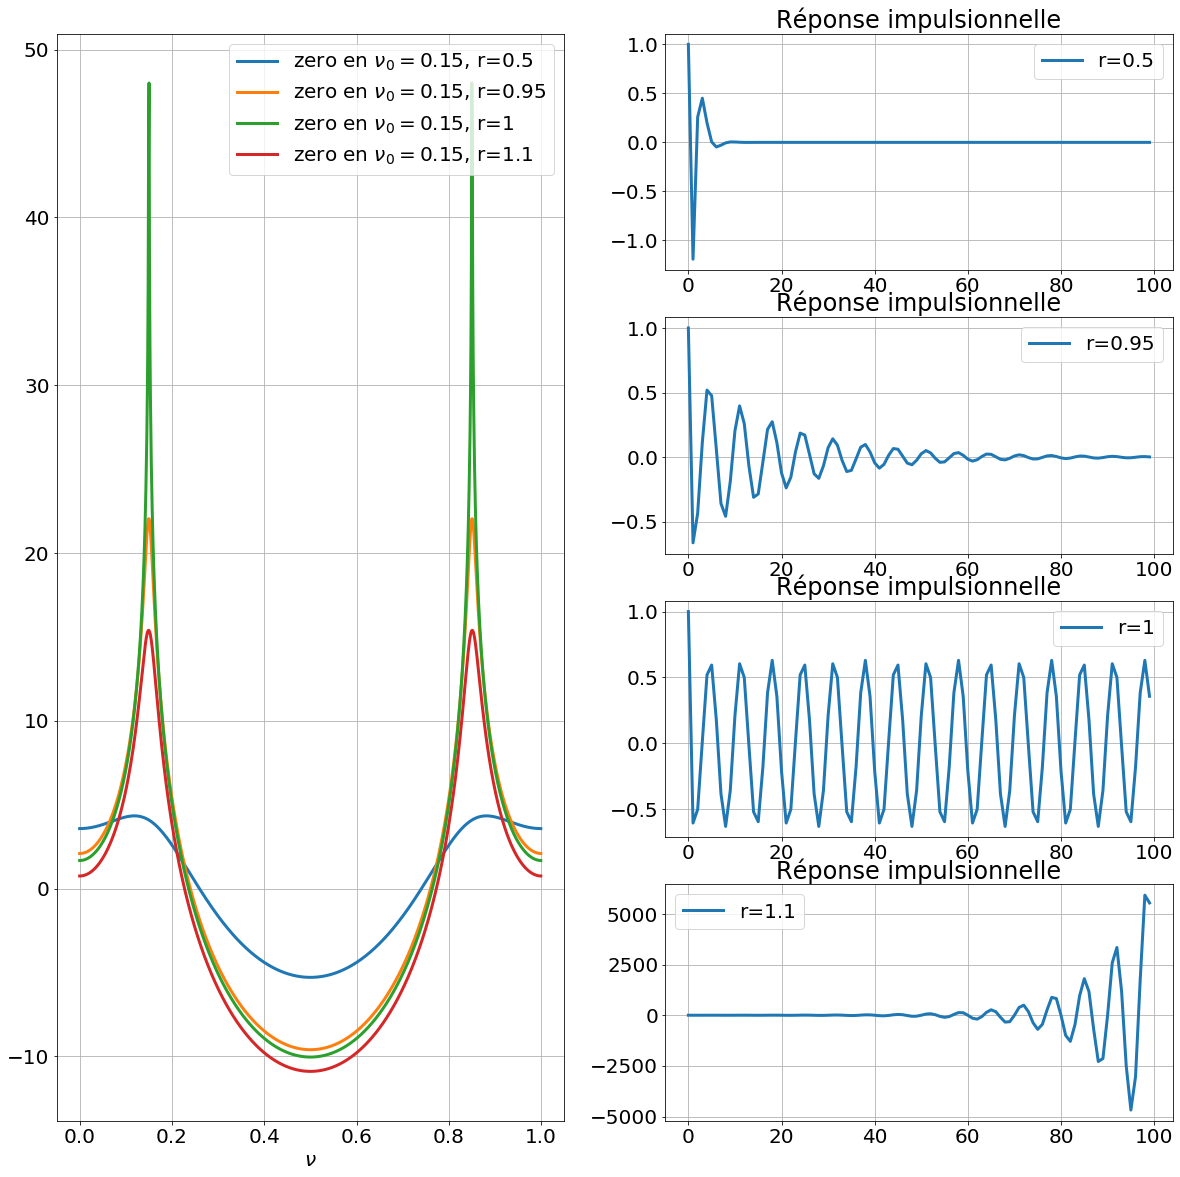

In [23]:
x = np.zeros(100)
x[0] = 1
nu0 = 0.15
fig=plt.figure(figsize=(20,20))
sp = fig.subplots(1, 2)
for i_r, r in enumerate([0.5, 0.95, 1, 1.1]):
    a = [1, -2*r*np.cos(2*np.pi*nu0), r**2]
    y = lfilter(b=b, a=a, x=x)
    
    plt.sca(sp[0])
    plot_filter_response(b=[1], a=a, label=r'zero en $\nu_0={}$, r={}'.format(nu0, r))

    plt.subplot(4,2,i_r*2+2)
    plt.plot(y, label=r'r={}'.format(r))
    plt.legend()
    plt.title('Réponse impulsionnelle')

plt.sca(sp[0])
plt.legend()

## Sur un son réel

Text(0.5, 1.0, 'Son entier')

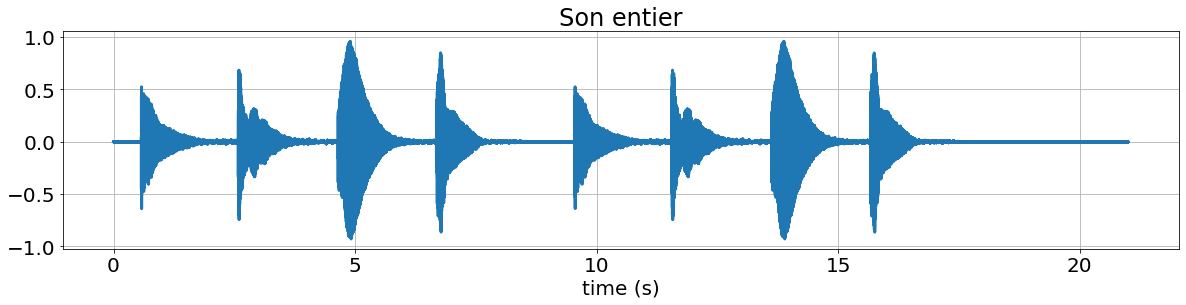

In [25]:
fs, x = wavfile.read(sound_path / '38.wav')
x = x[:, 0]
plot_sound(x, fs)
plt.title('Son entier')

/content/drive/My Drive/univ/master-2/sam/seance2/sam_utils.py:44: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(np.abs(x))


(0, 300)

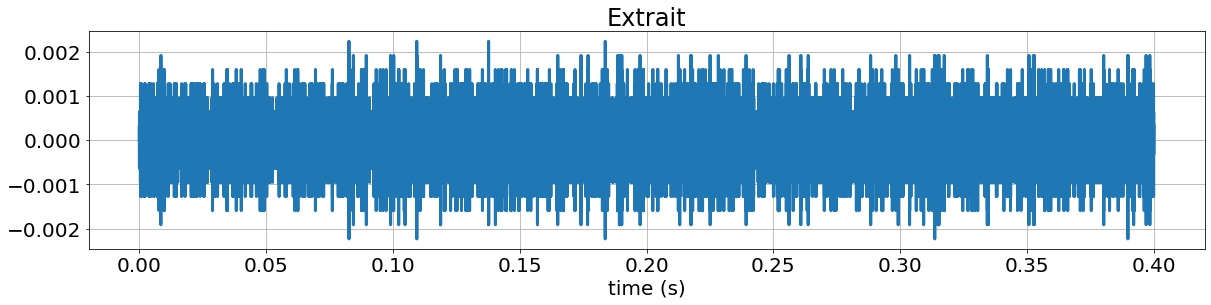

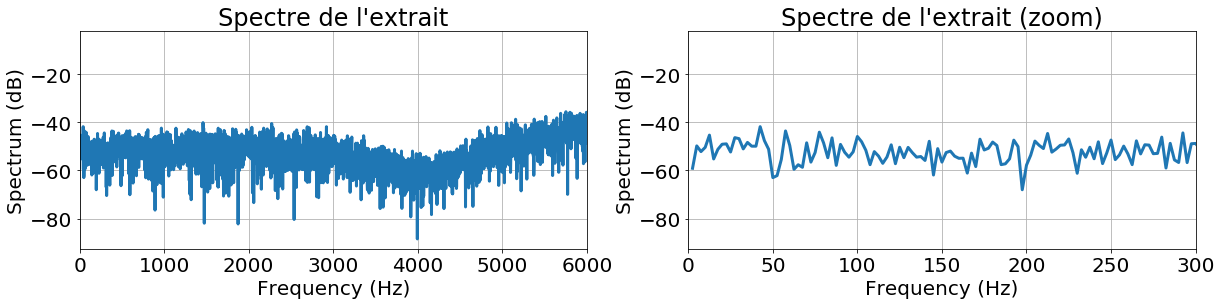

In [26]:
x0 = x[int(20.6*fs):int(21.6*fs)]
plt.figure()
plot_sound(x0, fs)
plt.title('Extrait')

plt.figure()
plt.subplot(121)
plot_spectrum(x0, fs)
plt.title("Spectre de l'extrait")
plt.xlim(0, 6000)
plt.subplot(122)
plot_spectrum(x0, fs)
plt.title("Spectre de l'extrait (zoom)")
plt.xlim(0, 300)

On applique un filtre FIR avec un zéro au niveau de la fréquence 175Hz:

nu0=0.003968253968253968


/content/drive/My Drive/univ/master-2/sam/seance2/sam_utils.py:44: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(np.abs(x))


Text(0.5, 1.0, 'Spectre (zoom)')

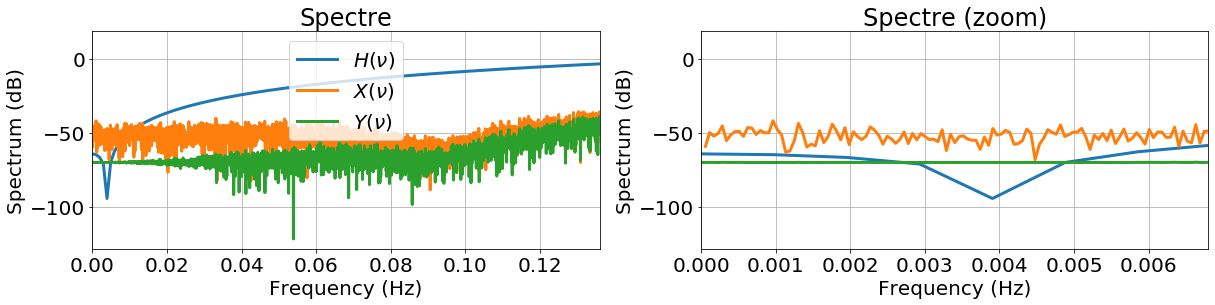

In [27]:
nu0 = 175 / fs
print('nu0={}'.format(nu0))
r = 1
b = [1, -2*r*np.cos(2*np.pi*nu0), r**2]

y = lfilter(b=b, a=[1], x=x0)


plt.figure()
plt.subplot(121)
plot_filter_response(b, label=r'$H(\nu)$')
plot_spectrum(x0, fs=1, label=r'$X(\nu)$')
plot_spectrum(y, fs=1, label=r'$Y(\nu)$')
plt.xlim(0, 6000/fs)
plt.legend()
plt.title('Spectre')

plt.subplot(122)
plot_filter_response(b)
plot_spectrum(x0, fs=1)
plot_spectrum(y, fs=1)
plt.xlim(0, 300/fs)
plt.title('Spectre (zoom)')

On applique ensuite un filtre IIR avec un pôle à la même fréquence, et un module légèrement inférieur à 1: on obtient ainsi un spectre proche de l'original, avec un contenu atténué à la fréquence $\nu_0$.

/content/drive/My Drive/univ/master-2/sam/seance2/sam_utils.py:44: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(np.abs(x))


Text(0.5, 1.0, 'Spectre (zoom)')

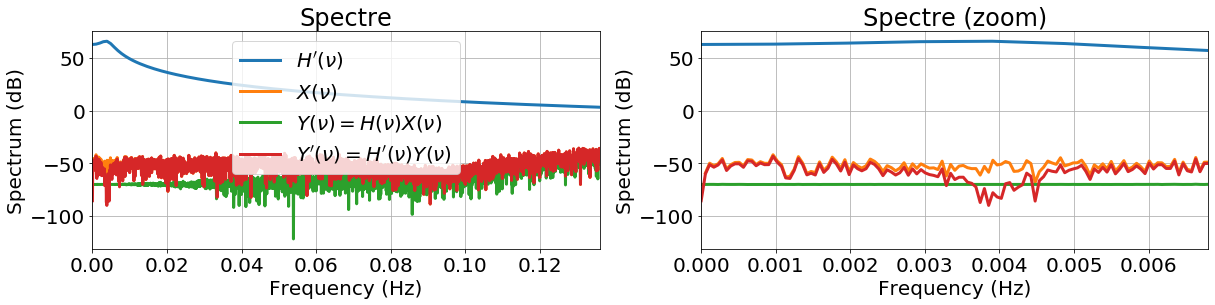

In [28]:
r = 0.99
a = [1, -2*r*np.cos(2*np.pi*nu0), r**2]

z = lfilter(b=[1], a=a, x=y)

plt.figure()
plt.subplot(121)
plot_filter_response(b=[1], a=a, label=r"$H'(\nu)$")
plot_spectrum(x0, fs=1, label=r'$X(\nu)$')
plot_spectrum(y, fs=1, label=r'$Y(\nu)=H(\nu)X(\nu)$')
plot_spectrum(z, fs=1, label=r"$Y'(\nu)=H'(\nu)Y(\nu)$")
plt.xlim(0, 6000/fs)
plt.legend()
plt.title('Spectre')

plt.subplot(122)
plot_filter_response(b=[1], a=a)
plot_spectrum(x0, fs=1)
plot_spectrum(y, fs=1)
plot_spectrum(z, fs=1)
plt.xlim(0, 300/fs)
plt.title('Spectre (zoom)')



Les deux filtrages peuvent être faits avec un seul filtre:

/content/drive/My Drive/univ/master-2/sam/seance2/sam_utils.py:44: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(np.abs(x))


Text(0.5, 1.0, 'Spectre (zoom)')

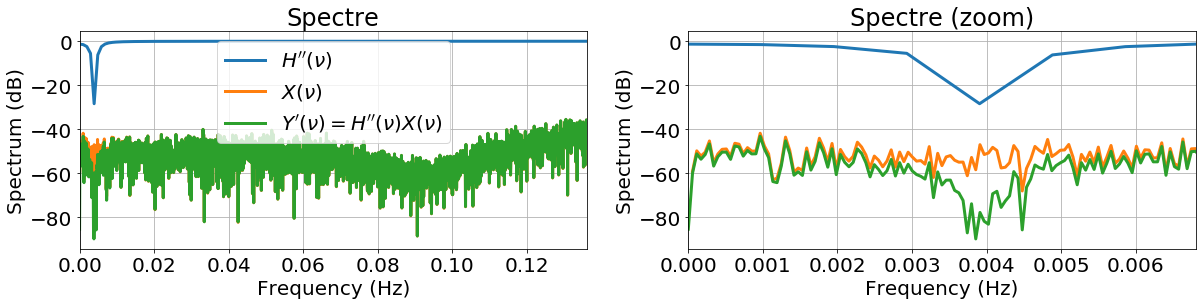

In [29]:
z = lfilter(b=b, a=a, x=x0)

plt.figure()
plt.subplot(121)
plot_filter_response(b=b, a=a, label=r"$H''(\nu)$")
plot_spectrum(x0, fs=1, label=r"$X(\nu)$")
plot_spectrum(z, fs=1, label=r"$Y'(\nu)=H''(\nu)X(\nu)$")
plt.xlim(0, 6000/fs)
plt.legend()
plt.title('Spectre')

plt.subplot(122)
plot_filter_response(b=b, a=a)
plot_spectrum(x0, fs=1)
plot_spectrum(z, fs=1)
plt.xlim(0, 300/fs)
plt.title('Spectre (zoom)')

